<center><img src="../meta/TRAIDENT.png" width="210"/></center>

# Preprocessing training-datacubes
---

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import xarray as xr
import sys
import os

## Open the zarr dataset 

In [226]:
zarrpath = "/scratch3/users/jdawson/parrot-cube-1-dirty-bad-chunking.zarr"
xrdata = xr.open_dataset(zarrpath, engine='zarr')
cube = xrdata['hdu']

## Get a chunk from the zarr dataset ready for fake signal injection

In [227]:
def getChunk(dataset, rank, blockSize=64):
    dec = (rank * blockSize, rank * blockSize + blockSize)
    ra = (0, 64)
    chunk = cube.isel(**{'DEC--SIN': slice(dec[0], dec[1]), 'RA---SIN': slice(ra[0], ra[1])}).data
    return chunk

In [228]:
chunk = getChunk(cube, 10)
print(f"Size of chunk: {chunk.shape}")

Size of chunk: (4608, 64, 64)


## Define a fake signal injection

In [229]:
def normal_sample(xarray, channel, amplitude, duration):
    ### Creates a normal distribution of points with no scatter
    a = 1 / (duration*np.sqrt(2*np.pi))
    b = np.exp(-0.5 * (((xarray-channel)/duration)**2))
    norm = a * b
    norm = amplitude * norm / norm.max()
    return norm

In [230]:
def inject_fake_signal(cube, row, column, channel, amplitude, duration):
    ### Injects a fake normal signal with amplitude: N * pixel rms, at a certain channel and sigme=duration. 
    xarray = np.arange(cube.shape[0]) # Make an empty array of zeros
    pixel = cube[:, row, column] # GET the current pixel timeseries
    rms = np.sqrt((pixel*pixel).sum()/cube.shape[0]) # Calculate the rms of the pixel 
    signal = normal_sample(xarray, channel, amplitude*rms, duration) # Make the clean signal
    signal[pixel == 0] = 0 # Remove signal where original cube == 0
    cube[:, row, column] += signal # Inject the signal into the cube
    return cube

In [231]:
pixel = inject_fake_signal(chunk, 30, 20, 3000, 1, 1000)

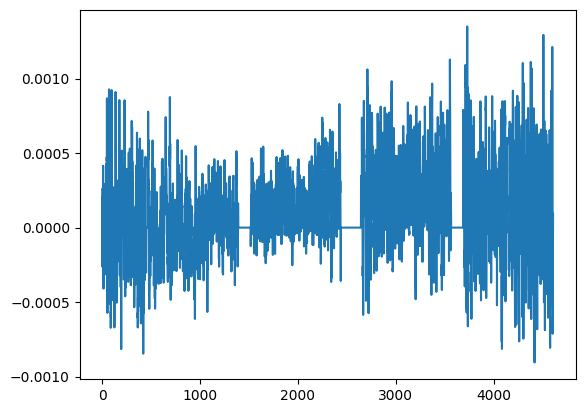

In [232]:
plt.close('all')
plt.figure()
plt.plot(pixel[:,30,20])

# Define a neighbourhood input vector calculator (numpy)

In [286]:
def get_neighbourhood(cube, row, column, channel, Nxy, Nt):
    assert Nxy % 2 != 0, f"Spatial selection Nxy: {Nxy} must be an odd number"
    assert Nt % 2 != 0, f"Temporal selection Nt: {Nt} must be an odd number"
    # Ensure the position is within bounds
    chan_start = min(max(0, channel - Nt), cube.shape[0] - Nt)
    chan_end = min(cube.shape[0], chan_start + Nt)
    row_start = min(max(0, row - Nxy), cube.shape[1] - Nxy)
    row_end = min(cube.shape[1], row_start + Nxy)
    col_start = min(max(0, column - Nxy), cube.shape[2] - Nxy)
    col_end = min(cube.shape[2], col_start + Nxy)
    return cube[chan_start:chan_end, row_start:row_end, col_start:col_end] # Select neighbourhood

def rescale_neighbourhood(neighbourhood):
    # Rescale to avoid moving into high incorrect flux-offset regions
    return neighbourhood - np.median(neighbourhood)

def flux_scale(neighbourhood):
    # Calculate the sum of the flux in the region
    return neighbourhood.sum()

def gradient(neighbourhood, xy, t):
    # Calculate the greedy and smooth gradients in each direction from the center of the neighbourhood
    grad_t = np.gradient(neighbourhood, axis=0)  # Time gradient
    grad_x = np.gradient(neighbourhood, axis=1)  # X gradient
    grad_y = np.gradient(neighbourhood, axis=2)  # Y gradient

    raw_gradient = np.abs([grad_t, grad_x, grad_y])
    greedy_gradient = raw_gradient.max((1,2,3)) # Greedy = looking at the maximum gradient in a direction
    smooth_gradient = np.abs(raw_gradient).mean((1,2,3)) # Smooth = looking at the average gradient in a direction
    return greedy_gradient, smooth_gradient

def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    # Calculate the position error and bounding box error for the anomaly proximity reward
    distance = np.sqrt((row-a_x)**2 + (column-a_y)**2 + (channel-a_t)**2)
    distance_weighted = 1 - (distance / (cube.shape[0] * cube.shape[1] * cube.shape[2])) # Penalises being a distance approaching the size of the cube away from the target
    bounding_xy = 1 - np.sqrt((Nxy - a_Nxy)**2) / cube.shape[1] # Penalises having a bounding box the size of the cube
    bounding_t = 1 - np.sqrt((Nt-a_Nt)**2) / cube.shape[0] # Penalises having a bounding box the size of the cube
    return distance_weighted, bounding_xy, bounding_t

In [287]:
row, column, channel, Nxy, Nt = 64, 64, 4201, 3, 3
a_x, a_y, a_t, a_Nxy, a_Nt = 64,64,4201,3,3
neighbourhood = get_neighbourhood(cube=chunk, row=row, column=column, channel=channel, Nxy=Nxy, Nt=Nt)
neighbourhood = rescale_neighbourhood(neighbourhood)
flux = flux_scale(neighbourhood)
greedy_grad, smooth_grad = gradient(neighbourhood, 50, 150)
distance_weighted, bounding_xy, bounding_t = anomaly_distance(chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)
input_vector = [flux, greedy_grad[0], greedy_grad[1], greedy_grad[2], smooth_grad[0], smooth_grad[1], smooth_grad[2]]

# Define a neighbourhood input vector calculator (torch)

In [291]:
def get_neighbourhood(cube, row, column, channel, Nxy, Nt):
    assert Nxy % 2 != 0, f"Spatial selection Nxy: {Nxy} must be an odd number"
    assert Nt % 2 != 0, f"Temporal selection Nt: {Nt} must be an odd number"
    
    # Ensure the position is within bounds
    chan_start = min(max(0, channel - Nt), cube.shape[0] - Nt)
    chan_end = min(cube.shape[0], chan_start + Nt)
    row_start = min(max(0, row - Nxy), cube.shape[1] - Nxy)
    row_end = min(cube.shape[1], row_start + Nxy)
    col_start = min(max(0, column - Nxy), cube.shape[2] - Nxy)
    col_end = min(cube.shape[2], col_start + Nxy)
    
    return cube[chan_start:chan_end, row_start:row_end, col_start:col_end]  # Select neighbourhood


def rescale_neighbourhood(neighbourhood):
    # Rescale to avoid moving into high incorrect flux-offset regions
    return neighbourhood - torch.median(neighbourhood)


def flux_scale(neighbourhood):
    # Calculate the sum of the flux in the region
    return neighbourhood.sum()


def gradient(neighbourhood):
    # Compute gradients manually using torch.diff (PyTorch's equivalent to np.gradient)
    grad_t = torch.diff(neighbourhood, dim=0, prepend=neighbourhood[0:1])  # Temporal gradient, pad at the start
    grad_x = torch.diff(neighbourhood, dim=1, prepend=neighbourhood[:, 0:1, :])  # X gradient, pad at the start
    grad_y = torch.diff(neighbourhood, dim=2, prepend=neighbourhood[:, :, 0:1])  # Y gradient, pad at the start
    # Convert gradients to absolute values
    raw_gradient = torch.abs(torch.stack([grad_t, grad_x, grad_y]))
    # Calculate greedy gradient (maximum gradient in a direction)
    greedy_gradient = raw_gradient.max(1)[0].max(1)[0].max(1)[0]
    # Calculate smooth gradient (mean gradient in a direction)
    smooth_gradient = raw_gradient.mean((1,2,3))
    return greedy_gradient, smooth_gradient

def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    # Calculate the position error and bounding box error for the anomaly proximity reward
    distance = torch.sqrt((row-a_x)**2 + (column-a_y)**2 + (channel-a_t)**2)
    distance_weighted = 1 - (distance / (cube.shape[0] * cube.shape[1] * cube.shape[2])) # Penalises being a distance approaching the size of the cube away from the target
    bounding_xy = 1 - torch.sqrt((Nxy - a_Nxy)**2) / cube.shape[1] # Penalises having a bounding box the size of the cube
    bounding_t = 1 - torch.sqrt((Nt-a_Nt)**2) / cube.shape[0] # Penalises having a bounding box the size of the cube
    return distance_weighted, bounding_xy, bounding_t

In [289]:
torch_chunk = torch.tensor(chunk)

In [288]:
row, column, channel = torch.tensor(10), torch.tensor(16), torch.tensor(2600) # Just random start position
Nxy, Nt = torch.tensor(11), torch.tensor(1001)
a_x, a_y, a_t, a_Nxy, a_Nt = torch.tensor(64),torch.tensor(64),torch.tensor(4201),torch.tensor(3),torch.tensor(3)

In [292]:
tneighbourhood = get_neighbourhood(cube=torch_chunk, row=row, column=column, channel=channel, Nxy=Nxy, Nt=Nt)
tneighbourhood = rescale_neighbourhood(tneighbourhood)
flux = flux_scale(tneighbourhood)
greedy_grad, smooth_grad = gradient(tneighbourhood)
distance_weighted, bounding_xy, bounding_t = anomaly_distance(chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)
input_vector = torch.tensor(torch.stack([torch.tensor(11), torch.tensor(301), 
                                         flux, 
                                         greedy_grad[0], greedy_grad[1], greedy_grad[2], 
                                         smooth_grad[0], smooth_grad[1], smooth_grad[2]]))

/tmp/ipykernel_296216/2410156124.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_vector = torch.tensor(torch.stack([torch.tensor(11), torch.tensor(301),


In [295]:
bounding_t

tensor(0.7834)